In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils.data_loaders import read_solution

In [63]:
VEHICLES = 25
CUSTOMERS = 100

SOLUTION = read_solution('data/raw/sintef_routes.txt')
print(SOLUTION)

{'1': array([81, 78, 76, 71, 70, 73, 77, 79, 80]), '2': array([57, 55, 54, 53, 56, 58, 60, 59]), '3': array([ 98,  96,  95,  94,  92,  93,  97, 100,  99]), '4': array([32, 33, 31, 35, 37, 38, 39, 36, 34]), '5': array([13, 17, 18, 19, 15, 16, 14, 12]), '6': array([90, 87, 86, 83, 82, 84, 85, 88, 89, 91]), '7': array([43, 42, 41, 40, 44, 46, 45, 48, 51, 50, 52, 49, 47]), '8': array([67, 65, 63, 62, 74, 72, 61, 64, 68, 66, 69]), '9': array([ 5,  3,  7,  8, 10, 11,  9,  6,  4,  2,  1, 75]), '10': array([20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 21])}


## [1] Load Data

In [64]:
customers_df = pd.read_csv('data/processed/c101.csv')
print(f"Number of customers: {len(customers_df)}")
customers_df.head()

Number of customers: 101


,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
0,1,40.0,50.0,0.0,0.0,1236.0,0.0
1,2,45.0,68.0,10.0,912.0,967.0,90.0
2,3,45.0,70.0,30.0,825.0,870.0,90.0
3,4,42.0,66.0,10.0,65.0,146.0,90.0
4,5,42.0,68.0,10.0,727.0,782.0,90.0


In [65]:
customers_df.iloc[1:].describe()

,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,51.500000,42.300000,48.590000,18.100000,426.800000,487.560000,90.0
std,29.011492,22.977591,21.367915,10.415121,282.203738,282.053198,0.0
min,2.000000,0.000000,5.000000,10.000000,10.000000,67.000000,90.0
25%,26.750000,25.000000,32.000000,10.000000,177.500000,237.750000,90.0
50%,51.500000,40.000000,47.500000,10.000000,417.500000,480.000000,90.0
75%,76.250000,58.500000,66.000000,20.000000,645.500000,710.000000,90.0
max,101.000000,95.000000,85.000000,50.000000,1054.000000,1127.000000,90.0


## [1.1] Optimal Solution

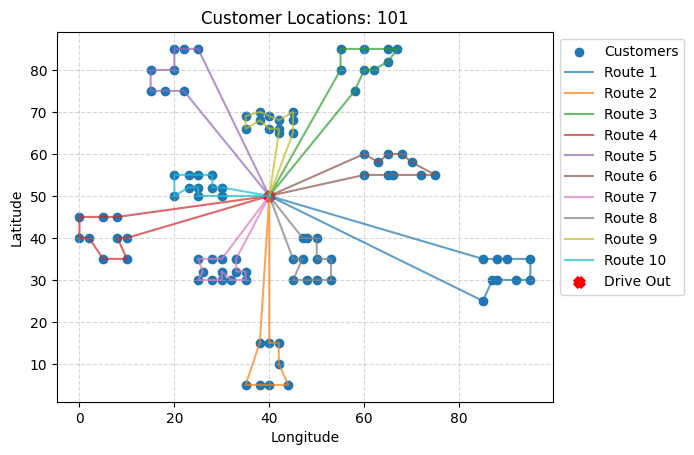

In [66]:
plt.title(f'Customer Locations: {len(customers_df)}')
plt.scatter(customers_df.iloc[1:]['Lng'], customers_df.iloc[1:]['Lat'], label='Customers')

for k, v in SOLUTION.items():
    # Add Origin to the start and end of the route
    routes = customers_df.iloc[v]
    routes = pd.concat([customers_df.iloc[[0]], routes, customers_df.iloc[[0]]], ignore_index=True)
    plt.plot(routes['Lng'], routes['Lat'], label=f"Route {k}", alpha=0.7)

plt.scatter(customers_df.iloc[0]['Lng'], customers_df.iloc[0]['Lat'], label='Drive Out', color='red', marker='x', linewidth=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## [2] Preprocessing

### [2.1] Remove origin
This dataset consists of 100 customers. But as you can see above, we currently have 101 rows. This is because the first index is the 'Driveout' location / 'Origin'. Thus, we need to remove this from the customers_data.

In [67]:
origin = customers_df.iloc[0]

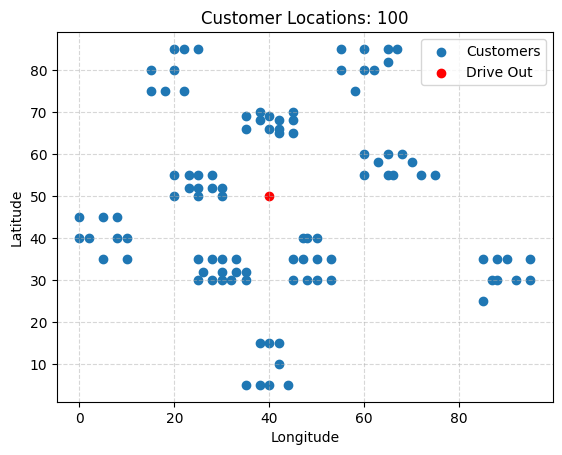

In [68]:
plt.title(f'Customer Locations: {len(customers_df) - 1}')
plt.scatter(customers_df.iloc[1:]['Lng'], customers_df.iloc[1:]['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Customers', 'Drive Out'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## [3] Problem

**REFERENCES**

Mirjalili, Ali, *Youtube*, https://www.youtube.com/watch?v=783ZtAF4j5g
(Cannot use graphs, must use matrixes for the mathematical modelling)[11:30]

• Depot: The starting and ending point for all vehicles. 
• Customers: Each customer has a location, a demand for goods, a time window for 
receiving the delivery, and a service time. 
• Vehicles:  Each  vehicle  has  a  limited  capacity  and  must  return  to  the  depot  after 
completing its route. 

### [3.1] Constraints
1. Each customer is visited exactly once by one vehicle. 
2. Deliveries occur within the specified time windows. 
3. The total demand on any route does not exceed the vehicle's capacity.

In [69]:
from typing import Tuple, Callable
from pandas.core.series import Series
matrix_shape = (CUSTOMERS + 1, CUSTOMERS + 1)

def create_matrix(matrix_shape: Tuple[int, int], frame: pd.DataFrame, function: Callable[[Series, Series], float]) -> np.ndarray:
    matrix = np.zeros(matrix_shape)
    for i, iv in frame.iterrows():
        for j, jv in frame.iterrows():
            matrix[i, j] = function(iv, jv)
    return matrix

def calculate_distance(x1: Tuple[float, float], x2: Tuple[float, float]) -> float:
    return np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)

distance_matrix = create_matrix(matrix_shape, customers_df, lambda i, j: calculate_distance((i['Lat'], i['Lng']), (j['Lat'], j['Lng'])))
pheromone_matrix = np.ones(matrix_shape)

In [70]:
print(distance_matrix)

[[ 0.         18.68154169 20.61552813 ... 30.8058436  33.54101966
  38.07886553]
 [18.68154169  0.          2.         ... 14.76482306 15.62049935
  19.72308292]
 [20.61552813  2.          0.         ... 13.92838828 14.14213562
  18.02775638]
 ...
 [30.8058436  14.76482306 13.92838828 ...  0.          5.83095189
  10.44030651]
 [33.54101966 15.62049935 14.14213562 ...  5.83095189  0.
   5.        ]
 [38.07886553 19.72308292 18.02775638 ... 10.44030651  5.
   0.        ]]


## Constants

In [71]:
ALPHA = .7
BETA = .3
NUMBER_OF_ANTS = 10
NUMBER_OF_ITERATIONS = 10

### Ant move to node probability formula
**We should set allowed to only be the most near neighbours**

$$P_{ij}(t) =\frac{[\tau_{ij}(t)]^\alpha * [n_{ij}]^\beta}{\sum_{k \in allowed}[\tau_{ik}(t)]^\alpha * [n_{ik}]^\beta}$$

In [74]:
from typing import List, Callable

class Ant:
    def __init__(self, starting_node: int):
        self.alpha = ALPHA
        self.beta = BETA
        self.visited_nodes = []
        self.current_node = starting_node

    def move(self):
        pass

class Colony:
    def __init__(self, pheromone_matrix: np.ndarray, objectives: List[Callable[[int, int], float]]):
        self.objective_functions = objectives
        self.pheromones = pheromone_matrix

    def create_ants(self, start_end_location: int) -> List[Ant]:
        """
        Create a list of ants with random starting locations.
        *TODO: Should start at the origin and end at the origin.*
        """
        # ant_locations = np.random.choice(pheromone_matrix.shape[0], size=pheromone_matrix.shape[0], replace=False) # Randomly select starting locations
        ants = [Ant(starting_location) for starting_location in range(pheromone_matrix.shape[0]) if starting_location != start_end_location]
        return ants

    def update_pheromones(self):
        pass

    def run(self, number_of_iterations: int, start_end_location: int):
        for _ in range(number_of_iterations):
            ants = self.create_ants(start_end_location)
            for ant in ants:
                ant.move()

In [72]:
def calculate_probability_at_node(i: int, j: int, visited: list[int], pheromone: np.ndarray, distance: np.ndarray, alpha: float, beta: float) -> float:
    objective = (distance[i, j] ** beta)
    nominator = (pheromone[i, j] ** alpha) * objective
    denominator = np.array([(pheromone[i, k] ** alpha) * (distance[i, k] ** beta) for k in visited]).sum()
    return nominator / denominator

def calculate_probabilities(visited: list[int], pheromone: np.ndarray, distance: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    current_node = visited[-1] # last node.
    return np.array([calculate_probability_at_node(current_node, j, visited, pheromone, distance, alpha, beta) for j in range(len(visited))])

In [73]:
node_probabilities = calculate_probabilities([1, 2, 20], pheromone_matrix, distance_matrix, ALPHA, BETA)
print(node_probabilities)

[0.38352223 0.49513816 0.50486184]


##

### [3.2] Cost Matrix

### [3.3] Pheromone Matrix